Block Maxima and Peaks Over Threshold Analysis

In [1]:
# EVT + dependencies for Anaconda kernel
!pip install yfinance pandas matplotlib seaborn scipy evt

# Install lmoments3 from GitHub
!pip install git+https://github.com/OpenHydrology/lmoments3.git

# Install scikit-extremes (GEV support)
!git clone https://github.com/kikocorreoso/scikit-extremes.git
%cd scikit-extremes
!pip install -e .
%cd ..

# Install thresholdmodeling (GPD support)
!git clone https://github.com/iagolemos1/thresholdmodeling.git
%cd thresholdmodeling
!pip install -e .
%cd ..


  Cloning https://github.com/OpenHydrology/lmoments3.git to /private/var/folders/6v/1zrv_7_d0zzd8j18ssjr64ch0000gn/T/pip-req-build-lq9equim
  Running command git clone --filter=blob:none --quiet https://github.com/OpenHydrology/lmoments3.git /private/var/folders/6v/1zrv_7_d0zzd8j18ssjr64ch0000gn/T/pip-req-build-lq9equim
  Resolved https://github.com/OpenHydrology/lmoments3.git to commit 7e19f97c23019ca68cbd526b8bd417c412438f1c
  Preparing metadata (setup.py) ... done
fatal: destination path 'scikit-extremes' already exists and is not an empty directory.
/Users/scottyap/Documents/M2R_EVT/scikit-extremes
Obtaining file:///Users/scottyap/Documents/M2R_EVT/scikit-extremes
  Preparing metadata (setup.py) ... done
  Attempting uninstall: scikit-extremes
    Found existing installation: scikit-extremes 0.0.1
    Uninstalling scikit-extremes-0.0.1:
      Successfully uninstalled scikit-extremes-0.0.1
  Running setup.py develop for scikit-extremes
/Users/scottyap/Documents/M2R_EVT
fatal: destin

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ExtremeLy import extremely as ely

[*********************100%***********************]  1 of 1 completed

Price        Close    High     Low    Open     Volume
Ticker        AMZN    AMZN    AMZN    AMZN       AMZN
Date                                                 
2010-01-04  6.6950  6.8305  6.6570  6.8125  151998000
2010-01-05  6.7345  6.7740  6.5905  6.6715  177038000
2010-01-06  6.6125  6.7365  6.5825  6.7300  143576000
2010-01-07  6.5000  6.6160  6.4400  6.6005  220604000
2010-01-08  6.6760  6.6840  6.4515  6.5280  196610000
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3773 entries, 2010-01-04 to 2024-12-30
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AMZN)   3773 non-null   float64
 1   (High, AMZN)    3773 non-null   float64
 2   (Low, AMZN)     3773 non-null   float64
 3   (Open, AMZN)    3773 non-null   float64
 4   (Volume, AMZN)  3773 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 176.9 KB
None


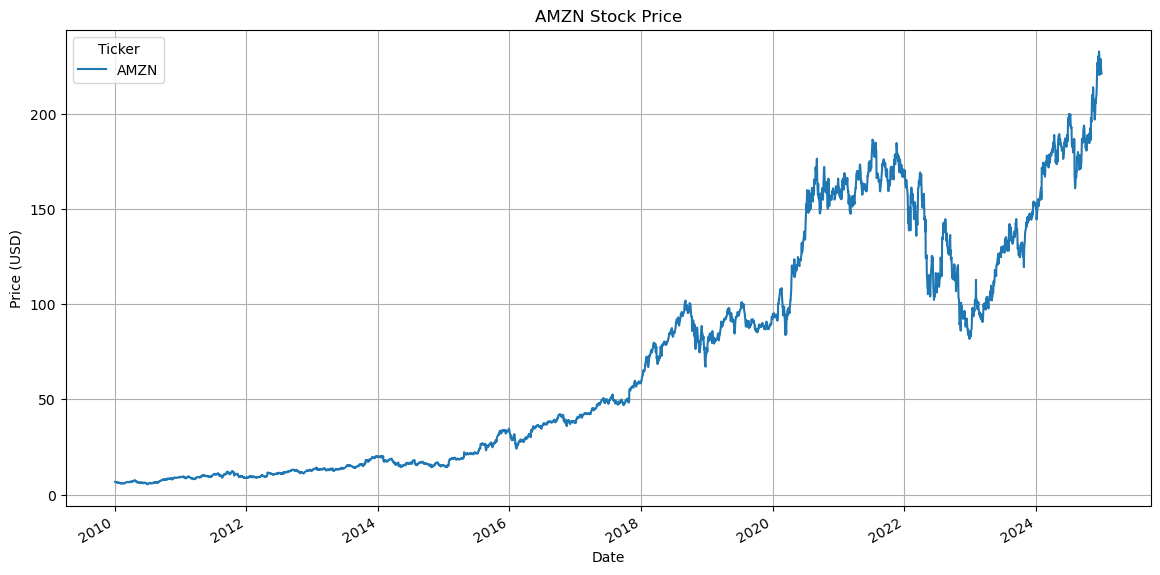

In [16]:
# Example: Download data for Amazon (AMZN) from 2010 to 2024
def download_stock_data(ticker, start_date, end_date):
    """
    Download stock data from Yahoo Finance.
    
    :param ticker: Stock ticker symbol
    :param start_date: Start date in 'YYYY-MM-DD' format
    :param end_date: End date in 'YYYY-MM-DD' format
    :return: DataFrame with stock data
    """
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data
ticker = 'AMZN'
start_date = '2010-01-01'
end_date = '2024-12-31'
AMZN_data = download_stock_data(ticker, start_date, end_date)

print(AMZN_data.head())
print(AMZN_data.info())
AMZN_data['Close'].plot(title=f'{ticker} Stock Price', figsize=(14, 7))
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid()
plt.show()

`data.pct_change()` calculates the **daily percentage return**:

$$
r_t = \frac{P_t - P_{t-1}}{P_{t-1}}
$$

Where:  
- \( P_t \) is today's price  
- \( P_{t-1} \) is yesterday’s price

`.dropna()` removes the first `NaN` value that results from the initial shift (since there's no previous day to compare for the first row).


Ticker          AMZN
Date                
2010-01-05  0.005883
2010-01-06 -0.018282
2010-01-07 -0.017160
2010-01-08  0.026717
2010-01-11 -0.024335


<Figure size 1000x400 with 0 Axes>

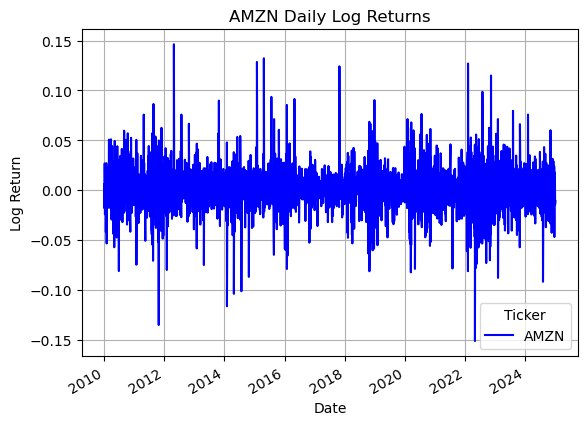

In [21]:
# Download just the 'Close' price
data = AMZN_data['Close'].dropna()

# Compute log returns
log_returns = np.log(data / data.shift(1)).dropna()
print(log_returns.head())


# Plot clean log returns
plt.figure(figsize=(10, 4))
log_returns.plot(title="AMZN Daily Log Returns", color='blue')
plt.ylabel("Log Return")
plt.xlabel("Date")
plt.grid(True)
plt.show()

In [22]:
# Flip returns for losses, and reset index
extreme_df = log_returns["AMZN"].copy().to_frame(name="Loss").reset_index()
extreme_df.rename(columns={"Close": "Loss"}, inplace=True)
extreme_df["Loss"] = -extreme_df["Loss"]  # flip sign for losses

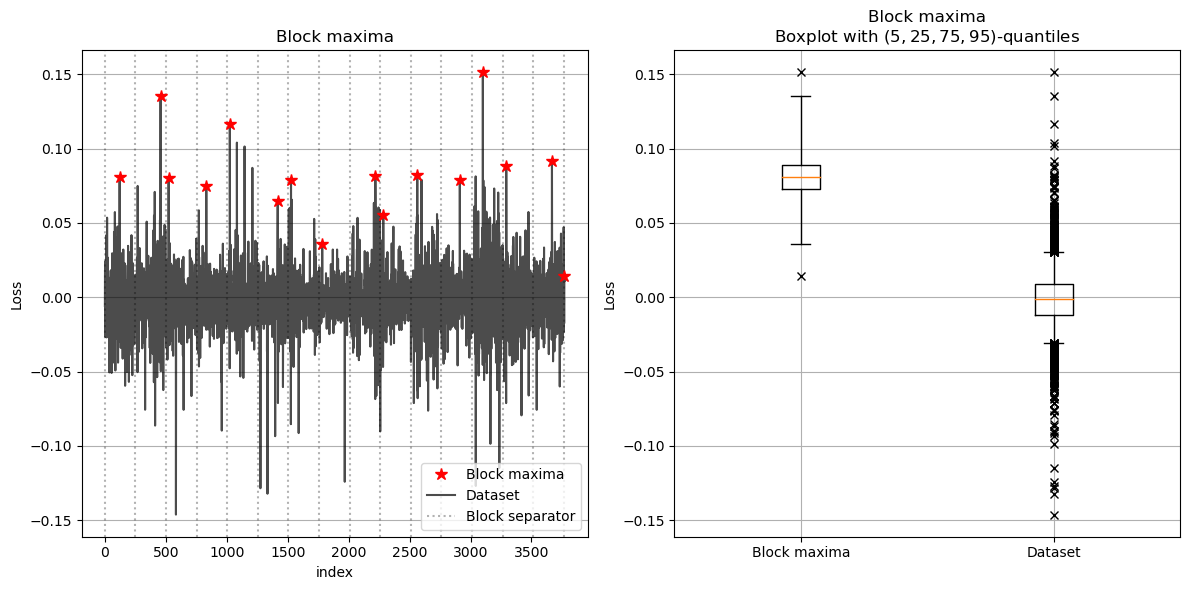

,Loss
0,0.081225
1,0.135325
2,0.080171
3,0.075161
4,0.116503
5,0.064961
6,0.079151
7,0.036061
8,0.081423
9,0.055321


In [23]:
# Here Y means Yearly, we can pass M for monthly, W for weekly and D for daily.
maxima = ely.getBM(sample=extreme_df, period="Y")

maxima

Now we can fit the maxima value to GEV distribution for estimating parameters. Here the default fit_method is MLE and default Confidence interval method is delta. Method of moments also can be used as a fit_method and bootstrap also can be used for ci_method.

🔧 fit_method: How do we estimate the parameters?

This determines the method used to fit the GEV model to the data:

1. MLE (Maximum Likelihood Estimation) ✅ default
	•	Finds the parameters that make the observed maxima most probable under the GEV model.
	•	Preferred because:
	•	Well-studied
	•	Easy to derive standard errors and confidence intervals
	•	But: may not be robust if sample size is small or data are poorly behaved

2. Method of Moments
	•	Matches sample moments (mean, variance, skewness) to the theoretical moments of the GEV distribution.
	•	Simpler, but:
	•	Less efficient than MLE
	•	Can be biased or unstable for small samples

📏 ci_method: How do we compute confidence intervals?

This tells us how uncertain our parameter estimates are, which is crucial for risk management.

1. Delta Method ✅ default
	•	Uses a Taylor approximation around the MLE estimates to approximate confidence intervals.
	•	Fast and analytical.
	•	Assumes normality and may be less accurate for small samples or skewed distributions.

2. Bootstrap
	•	Resamples the data many times to empirically estimate the variability of the parameter estimates.
	•	More accurate and robust, especially for small or complex datasets.
	•	But: computationally expensive.


In [7]:
maxima_df = maxima.reset_index()
maxima_df.columns = ["Index", "Loss"]  # Ensures 2 columns

#Fitting the GEV distribution with maxima values. 
fit = ely.gevfit(sample=maxima_df, fit_method="mle", ci=0, ci_method="delta")

#Getting estimated distribution parameters for GEV fit.
params=ely.gevparams(model=fit)
params

OrderedDict([('shape', 0.10219222704326074),
             ('location', 0.07477177218657272),
             ('scale', 0.024340554748597424)])

When shape > 0: Fréchet

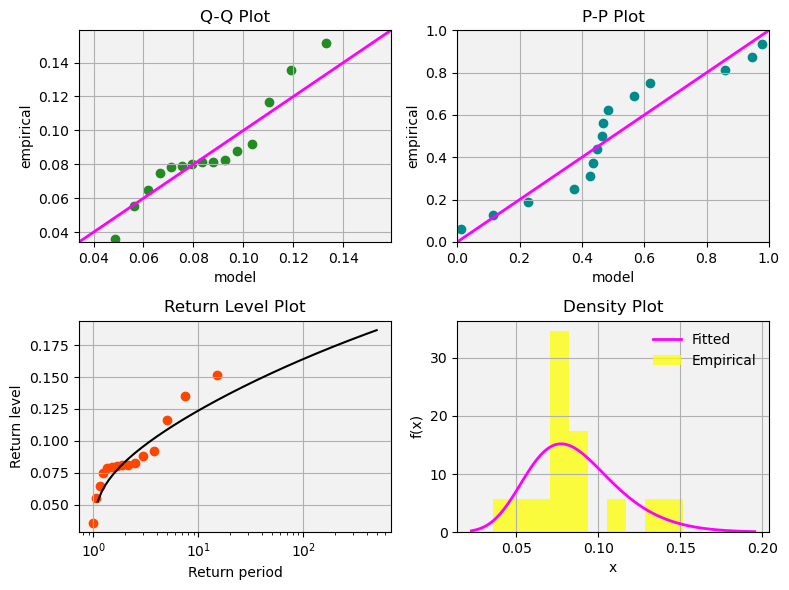

In [8]:
#Summarizing the GEV model.
ely.gevsummary(model=fit)

🔍 Top Left: Q-Q Plot (Quantile-Quantile)
	•	Compares quantiles of your empirical data vs the model’s predicted quantiles.
	•	If points fall along the magenta line, it means the model and data agree well.
	•	Here: Slight deviation at higher quantiles → possible underestimation of some larger extremes.

⸻

🔍 Top Right: P-P Plot (Probability-Probability)
	•	Compares cumulative probabilities of the empirical data vs the fitted GEV model.
	•	Diagonal fit = good match.
	•	Here: Small curvature in middle range → could suggest a slight bias in probability assignment by the model.

⸻

📈 Bottom Left: Return Level Plot
	•	Plots return periods (e.g. 10, 50, 100-year) vs return levels (extreme quantiles).
	•	Black curve: GEV model’s extrapolated return levels.
	•	Orange dots: Empirical return levels.
	•	Good for assessing how well the model extrapolates extreme events.
	•	Here: Fair agreement at short periods, some deviation at long-period extrapolations.

⸻

📊 Bottom Right: Density Plot
	•	Compares the empirical density (histogram of observed maxima) with the GEV PDF (Probability Density Function).
	•	Yellow bars: Empirical distribution.
	•	Magenta curve: Fitted GEV.
	•	Here: Model captures general shape well, but may underfit peak frequency.

⸻

✅ Overall: Is the Model Good?

This figure is designed to validate the GEV fit:
	•	Good fit: Points lie close to diagonal in Q-Q and P-P plots, return levels align, density curves match.
	•	Deviations (especially in tails): Suggest model misspecification or outliers → consider using bootstrap CIs or alternate thresholds.

GPD

📊 What does this plot show?

It plots:
	•	X-axis = potential threshold values
	•	Y-axis = the mean excess over threshold (i.e., the average size of exceedances above that threshold)

The blue line shows the sample mean excess values, and the shaded region gives a confidence band (here, 95% because alpha=0.05).

⸻

🧠 What is the Mean Residual Life?

For a threshold u, the mean residual life (MRL) is defined as:

e(u) = E[X - u \mid X > u]

This is the expected excess over the threshold, conditional on the data exceeding the threshold.

⸻

✅ How is this used in EVT?

In the Peaks-Over-Threshold (POT) method, we want to choose a threshold u such that:
	•	The exceedances above u approximately follow a Generalized Pareto Distribution (GPD)
	•	One condition for this is that e(u) should be linear in u

⸻

🔍 What to look for in the plot?
	•	Stable / Linear section → choose a threshold from here
	•	Loss of linearity or erratic behavior → GPD model may no longer hold


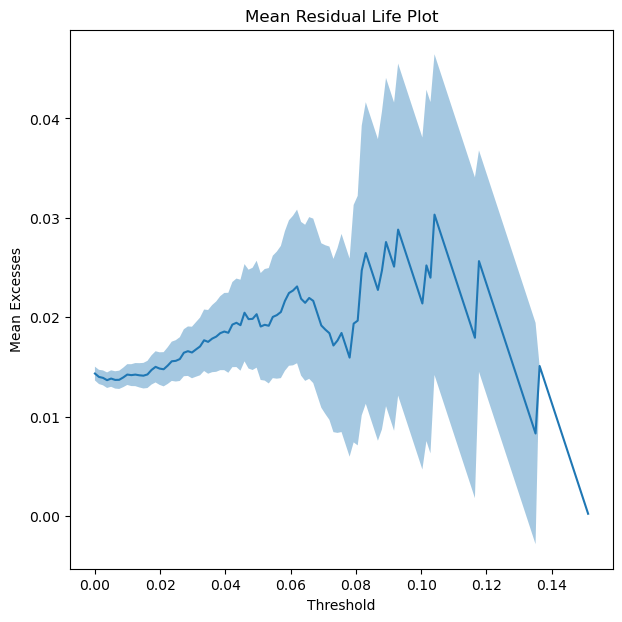

In [ ]:
# for finding appropriate threshold value for Peak-Over-Threshold method.
ely.MRL(sample=extreme_df,alpha=0.05)

🔍 In your plot:
	•	From 0.00 to ~0.06, the curve looks relatively stable and linear.
	•	From ~0.07 onwards, it becomes more erratic, and the confidence band widens significantly.
	•	Past 0.10, the curve loses stability entirely — showing high variance and a steep drop, suggesting too few exceedances.

,Date,Loss
index,,
18,2010-02-01,0.053558
82,2010-05-04,0.057325
121,2010-06-29,0.081225
269,2011-01-28,0.074896
343,2011-05-16,0.050888
403,2011-08-10,0.054921
409,2011-08-18,0.070898
452,2011-10-19,0.051967
457,2011-10-26,0.135325


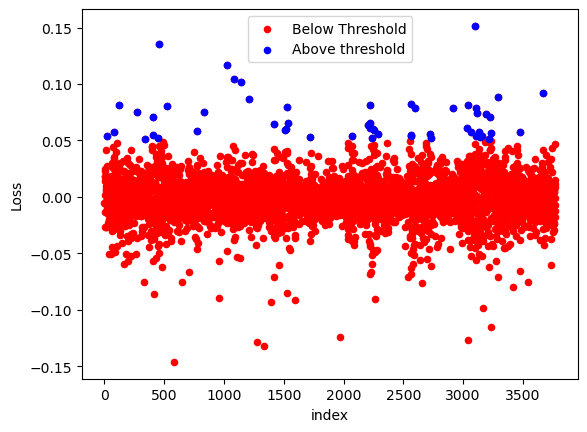

In [26]:
#Getting large claims using POT method using threshold value as 0.06.
pot=ely.getPOT(sample=extreme_df,threshold=0.05)
pot

In [27]:
#Fitting GPD with large claims obtained using POT method.
gpdfit=ely.gpdfit(sample=extreme_df,threshold=0.05)

#Getting estimated distribution parameters for GPD fit.
ely.gpdparams(fit=gpdfit)

Shape: 0.03747427290031638
Scale: 0.019125926195406675


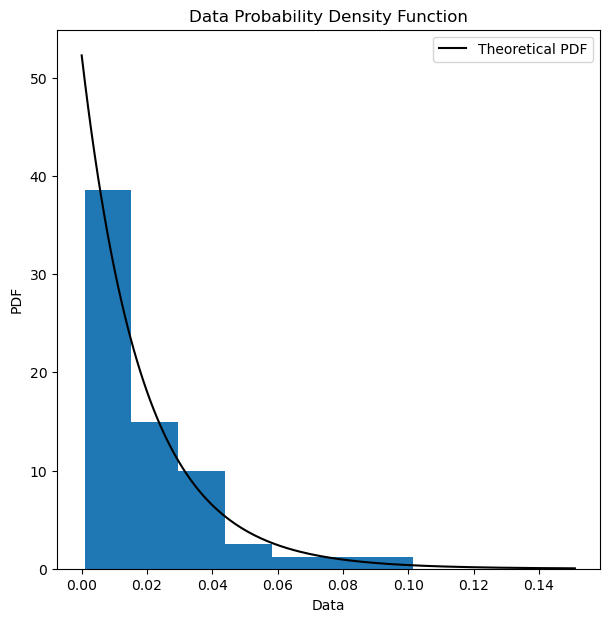

In [29]:
#Data Probability Density Function plot.
ely.gpdpdf(sample=extreme_df,threshold=0.05,bin_method="sturges",alpha=0.5)

GEV: 'shape', 0.10219222704326074)
GPD: Shape: 0.03747427290031638

GEV
Block maxima (e.g. annual)
Good for infrequent extremes

GPD
All values exceeding threshold
Good for more frequent extremes


In [30]:
print(dir(ely))

['BlockMaxima', 'Dataset', 'GPDMLE', 'MRL', 'PeaksOverThreshold', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'getBM', 'getPOT', 'gevfit', 'gevparams', 'gevsummary', 'gpdcdf', 'gpdfit', 'gpdparams', 'gpdpdf', 'gpdppplot', 'gpdqqplot', 'mt', 'np', 'pd', 'plt', 'sk', 'sns', 'stats', 'survivalFunction']
